## Importing Packages

In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [2]:
from fl_mnist_implementation_utils import *

## Loading Dataset & Data Preprocessing

In [3]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        im_gray_resized = cv2.resize(im_gray, (48,69), interpolation = cv2.INTER_AREA)
        #image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(im_gray_resized/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels

In [4]:
#declear path to your mnist data folder
img_path = r'D:\Important Files\Dataset Collection\Image Classification\Facial Expression\CK+_Complete'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=100)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=7)

[INFO] processed 100/1635
[INFO] processed 200/1635
[INFO] processed 300/1635
[INFO] processed 400/1635
[INFO] processed 500/1635
[INFO] processed 600/1635
[INFO] processed 700/1635
[INFO] processed 800/1635
[INFO] processed 900/1635
[INFO] processed 1000/1635
[INFO] processed 1100/1635
[INFO] processed 1200/1635
[INFO] processed 1300/1635
[INFO] processed 1400/1635
[INFO] processed 1500/1635
[INFO] processed 1600/1635


## Creation of Local Clients & Data Distribution

In [5]:
def create_clients(image_list, label_list, num_clients=3, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [6]:
#create clients
clients = create_clients(X_train, y_train, num_clients=3, initial='client')

In [7]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [8]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the train set  
train_batched = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(len(y_train))
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

## Building CNN Model

In [16]:
class CNNModel:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.1))
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [17]:
lr = 0.001 
comms_round = 20
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True)

## Training & Aggregating for Federated Implementation

In [18]:
Accu = []
Loss = []
Tr_Accu = []
Tr_Loss =[]

In [19]:
#initialize global model
mcnn_global = CNNModel()
global_model = mcnn_global.build((69, 48, 1), 7)
        
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        mcnn_local = CNNModel()
        local_model = mcnn_local.build((69, 48, 1), 7)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=5, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_train, y_train) in train_batched:
        global_train_acc, global_train_loss = test_train_model(X_train, y_train, global_model, comm_round)
        Tr_Accu.append(global_train_acc)
        Tr_Loss.append(global_train_loss)
    for(X_test, y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, y_test, global_model, comm_round)
        Accu.append(global_acc)
        Loss.append(global_loss)

comm_round: 0 | global_training_acc: 5.642% | global_training_loss: 2.0271222591400146
comm_round: 0 | global_acc: 4.268% | global_loss: 2.037933588027954
comm_round: 1 | global_training_acc: 5.642% | global_training_loss: 1.9933056831359863
comm_round: 1 | global_acc: 4.268% | global_loss: 2.007617235183716
comm_round: 2 | global_training_acc: 5.642% | global_training_loss: 2.0659780502319336
comm_round: 2 | global_acc: 4.268% | global_loss: 2.0801641941070557
comm_round: 3 | global_training_acc: 34.534% | global_training_loss: 1.8026365041732788
comm_round: 3 | global_acc: 26.829% | global_loss: 1.8339459896087646
comm_round: 4 | global_training_acc: 70.700% | global_training_loss: 1.4934931993484497
comm_round: 4 | global_acc: 60.976% | global_loss: 1.551643967628479
comm_round: 5 | global_training_acc: 88.851% | global_training_loss: 1.311095952987671
comm_round: 5 | global_acc: 81.098% | global_loss: 1.3915233612060547
comm_round: 6 | global_training_acc: 97.077% | global_training

## Evaluation

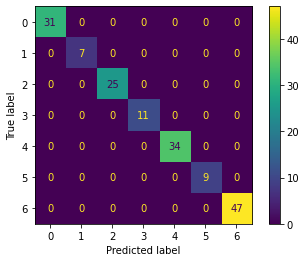

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred = global_model.predict(X_test)
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, accuracy_score

y_pred_proba = global_model.predict(X_test)

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)       

ROC_AUC Score: 1.0
Cohen_Kappa Score: 1.0
F1 Score: 1.0
Matthews Correlation Coefficient: 1.0
Log Loss: 0.0007602986914624977
Accuracy: 1.0


Text(0, 0.5, 'Loss')

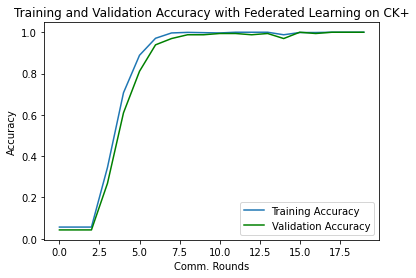

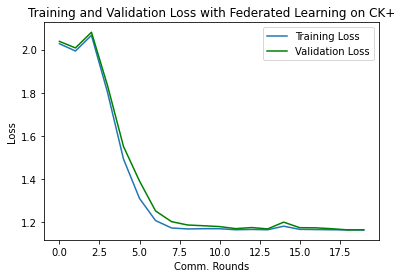

In [22]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = Tr_Accu
val_acc  = Accu
loss     = Tr_Loss
val_loss = Loss

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
plt.title ('Training and Validation Accuracy with Federated Learning on CK+')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
plt.title ('Training and Validation Loss with Federated Learning on CK+')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Loss')